In [1]:
# We set the path of the (so nicely nice) gaiaunlimited stuff BEFORE importing gaiaunlimited stuff
import os
os.environ['GAIAUNLIMITED_DATADIR'] = '/home/rafaelbertolotto/gaiaunlimited_files'

import numpy as np
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import warnings
from matplotlib import pyplot as plt
from gaiaunlimited.selectionfunctions import DR3RVSSelectionFunction
from gaiaunlimited.selectionfunctions import DR3SelectionFunctionTCG_hpx7
from astropy import coordinates
from astropy.coordinates import ICRS
from astropy.coordinates import Galactic
import astropy.units as u
from astropy.coordinates import (CartesianRepresentation,CartesianDifferential)
from astropy.coordinates import SkyCoord
from scipy import interpolate as interp

import mass_photometry_tools as massPhoto
import group_simulator_tools as GST

warnings.filterwarnings("ignore")
sns.set_context("talk")
mpl.style.use("seaborn")
sns.set_context("paper",font_scale=1.5)
sns.set_style("whitegrid")

In [2]:
# MG error data builded based on GDR3 MG error
MGerrInterp     = pd.read_csv('builded_or_modified_cat/MGerrInterp.csv')

# Photometric and kinematic errors data from GDR3
allErrorsOriginal = pd.read_csv('builded_or_modified_cat/gdr3MSPMS.csv',usecols=['phot_g_mean_mag',
                                                                                 'parallax',
                                                                                 'MG_err',
                                                                                 'BP_err',
                                                                                 'RP_err',
                                                                                 'G_err',
                                                                                 'parallax_error',
                                                                                 'radial_velocity_error',
                                                                                 'pmra_error',
                                                                                 'pmdec_error'])

In [3]:
allErrorsOriginal['MG'] = allErrorsOriginal.phot_g_mean_mag+5-5*np.log10(1000/allErrorsOriginal.parallax)
allErrorsOriginal['BR_err'] = np.sqrt(allErrorsOriginal.BP_err**2+allErrorsOriginal.RP_err**2)
Gmin = allErrorsOriginal.MG.min()
Gmax = allErrorsOriginal.MG.max()
N = 20
MGbins = np.arange(Gmin,Gmax,(Gmax-Gmin)/N)

MGtoErrToInterpolate = pd.DataFrame()
nSigmaMG = 10
nSigmaBR = 10

for i in np.arange(0,len(MGbins)-1,1):
    binMin  = MGbins[i]
    binMax  = MGbins[i+1]
    allErrorsOriginalBin = allErrorsOriginal[(allErrorsOriginal.MG >= binMin) & (allErrorsOriginal.MG < binMax)]
    allErrorsOriginalBin = pd.DataFrame({'MG':[(binMin+binMax)/2],
                                         'MG_err':[allErrorsOriginalBin.MG_err.median()+nSigmaMG*allErrorsOriginalBin.MG_err.std()],
                                         'BR_err':[np.sqrt((allErrorsOriginalBin.BP_err.median()+nSigmaBR*allErrorsOriginalBin.BP_err.std())**2+\
                                                           (allErrorsOriginalBin.RP_err.median()+nSigmaBR*allErrorsOriginalBin.RP_err.std())**2)]})
    MGtoErrToInterpolate = pd.concat([MGtoErrToInterpolate,allErrorsOriginalBin],axis=0).reset_index(drop=True)

MGtoMGerr = interp.interp1d(MGtoErrToInterpolate.MG,MGtoErrToInterpolate.MG_err)
MGtoBRerr = interp.interp1d(MGtoErrToInterpolate.MG,MGtoErrToInterpolate.BR_err)

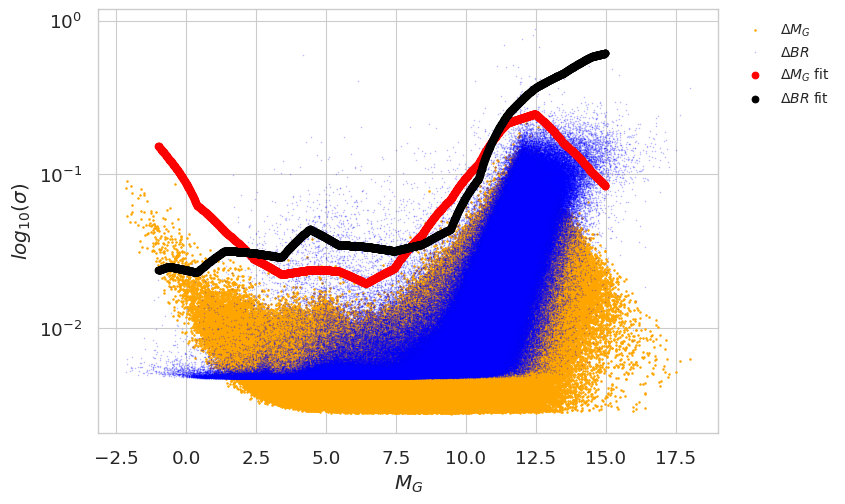

In [4]:
allMG = np.arange(-1,15,0.01)
plt.scatter(allErrorsOriginal.MG,allErrorsOriginal.MG_err,s=1,label=r'$\Delta M_G$',color='orange')
plt.scatter(allErrorsOriginal.MG,np.sqrt(allErrorsOriginal.BP_err**2+allErrorsOriginal.RP_err**2),s=0.01,label=r'$\Delta BR$',color='blue')
plt.scatter(allMG,MGtoMGerr(allMG),label=r'$\Delta M_G$ fit',color='red')
plt.scatter(allMG,MGtoBRerr(allMG),label=r'$\Delta BR$ fit',color='black')
plt.xlabel(r'$M_G$')
plt.ylabel(r'$log_{10}(\sigma)$')
plt.yscale('log')
plt.legend(bbox_to_anchor=(0.0, 0.0, 1.2, 1.),fontsize=10)
plt.show()

In [5]:
# Definition of general variables
rvstd           = [10,5,15,0.5,2,3]
rvmean          = [30,50,20,10,5,2]
age             = 1e7
dG              = 0.25     
sample_class    = '5d'

# We load the selection function for Gaia DR3 and the Gaia DR3 RVs
dr3sf           = DR3SelectionFunctionTCG_hpx7()
rvssf           = DR3RVSSelectionFunction()

In [6]:
# We build the family of kinematic error cumulative distribution per G bin
allErrors                       = allErrorsOriginal.drop([]).copy()
allErrorDistributions           = {}
errorNames                  = allErrors.drop(['phot_g_mean_mag'],axis=1).columns
if sample_class == '6d':
    allErrors                   = allErrors[allErrors.radial_velocity_error.isnull().values == False]
    errorNames                  = allErrors.drop(['phot_g_mean_mag'],axis=1).columns
    
for i in np.arange(0,len(errorNames),1):
    errorDistributions          = GST.accumulativeDistributionInterpolator1D(dataToInterpolate   = allErrors,
                                                                             dBin                = dG,
                                                                             columnBin           = 'phot_g_mean_mag',
                                                                             columnY             = errorNames[i])
    allErrorDistributions.update({errorNames[i]:errorDistributions})   
    
# We set the G magnitude limit to filter the generated clusters
GLimToFilter = [allErrors.phot_g_mean_mag.min(),allErrors.phot_g_mean_mag.max()]

In [7]:
N                   = int(1e4)
minMass             = 0.002
maxMass             = 10
dMass               = (np.log10(maxMass)-np.log10(minMass))/N
s                   = 1e-4
dCurveParameter     = 1e-5
syntheticData       = pd.DataFrame({'mass':10**np.arange(np.log10(minMass),np.log10(maxMass),dMass)}).sort_values(by=['mass'],ascending=False).reset_index(drop=True)
syntheticData       = pd.concat([syntheticData,massPhoto.massToPhoto_baraffe_PARSEC(syntheticData,'mass',age).reset_index(drop=True).astype('float')],axis=1,join='inner')
syntheticData['BR'] = syntheticData.G_BP-syntheticData.G_RP


inputColumns = ['BR','G','mass']

curve,tck = massPhoto.curveInterpolator(inputData         = syntheticData,
                                        columns           = inputColumns,
                                        s                 = s,
                                        dCurveParameter   = dCurveParameter)

parameterValues = massPhoto.curveParameterValueFinder(data                 = syntheticData,
                                                      columns              = inputColumns,
                                                      curve                = curve,
                                                      curveParameterColumn = 'curveParameter')
from scipy import interpolate as interp
BR,G,masses = interp.splev(parameterValues,tck)

In [8]:
# We create a synthetic group
N = int(1e3)
realAndObservedGroup = GST.groupGenerator(N                             = N,
                                          stdArray                      = rvstd,
                                          meanArray                     = rvmean,
                                          Age                           = age,
                                          dG                            = dG,
                                          dr3maps                       = dr3sf,
                                          rvmaps                        = rvssf,
                                          allErrorFunctions             = allErrorDistributions,
                                          GLimToFilter                  = GLimToFilter)

observedGroup   = realAndObservedGroup['observed']
realGroup       = realAndObservedGroup['real']

In [9]:
observedGroup['BR'] = observedGroup.phot_bp_mean_mag-observedGroup.phot_rp_mean_mag
realGroup['BR'] = realGroup.phot_bp_mean_mag-realGroup.phot_rp_mean_mag
syntheticData['BR'] = syntheticData.G_BP-syntheticData.G_RP
groupToAnalyse = observedGroup

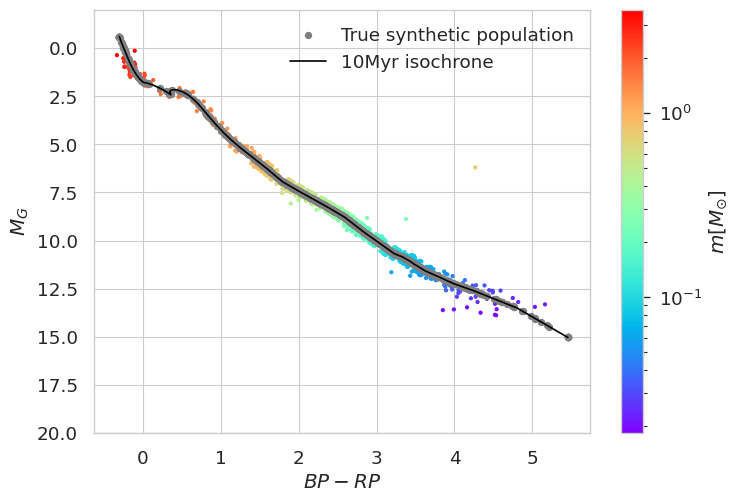

In [10]:
plt.scatter(observedGroup.BR,observedGroup.MG,s=5,c=observedGroup.mass,cmap='rainbow',norm=mpl.colors.LogNorm())
plt.colorbar(label=r'$m[M_{\odot}]$')
plt.scatter(realGroup.BR,realGroup.MG,s=20,color='grey',label='True synthetic population')
plt.plot(syntheticData.BR,syntheticData.G,color='black',label='10Myr isochrone')
plt.legend()
plt.xlabel(r'$BP-RP$')
plt.ylabel(r'$M_G$')
plt.ylim(20,-2)
plt.savefig('10MyrCMDToyModelForIMF.png',bbox_inches='tight')

In [11]:
intMass     = massPhoto.DCMtoMassRelation(data          = groupToAnalyse.drop('BR',axis=1),
                                          colorColumns  = ['phot_bp_mean_mag','phot_rp_mean_mag'],
                                          magColumn     = 'MG',
                                          massColumn    = 'mass',
                                          age           = age)

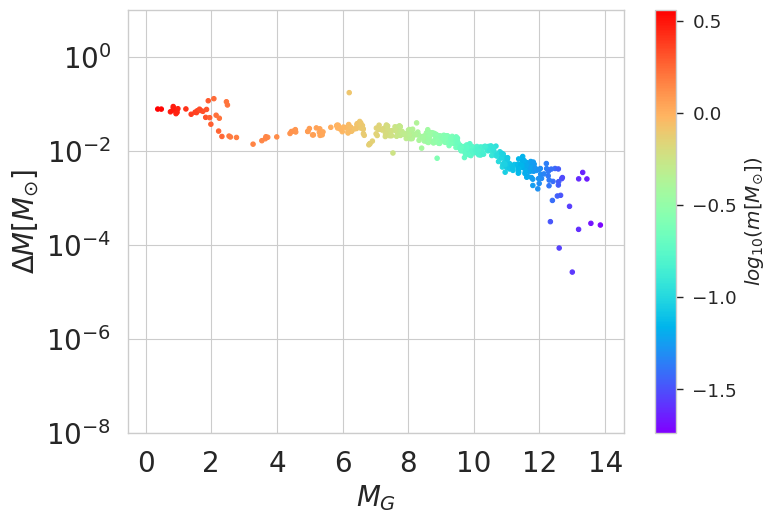

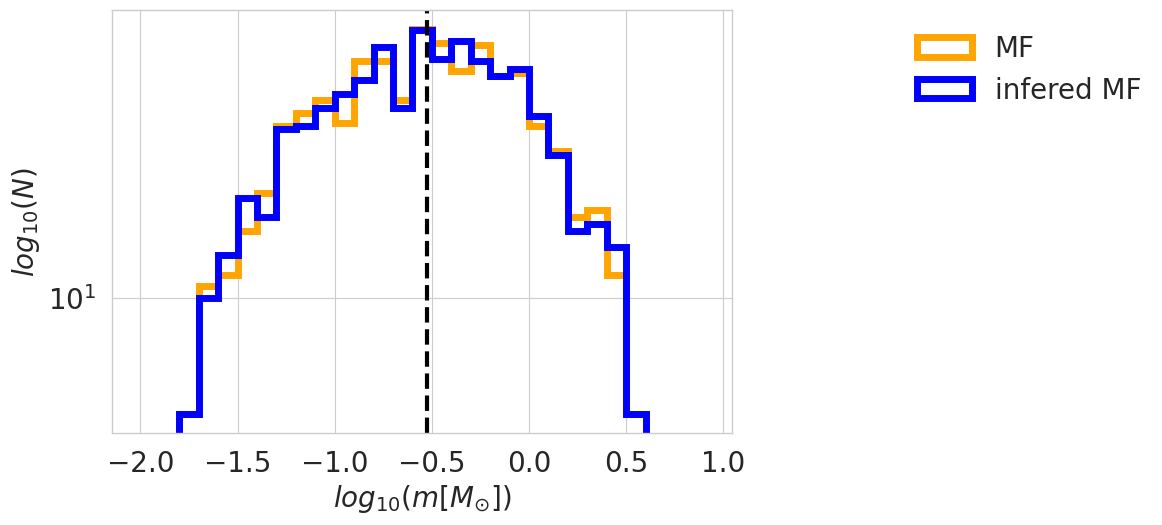

In [12]:
plt.scatter(groupToAnalyse.MG,groupToAnalyse.mass-intMass.interpolatedMass,s=10,label='observed cluster',c=np.log10(groupToAnalyse.mass),cmap='rainbow')
plt.colorbar(label=r'$log_{10}(m[M_{\odot}])$')
plt.yscale('log')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(r'$M_G$',fontsize=20)
plt.ylabel(r'$\Delta M[M_{\odot}]$',fontsize=20)
plt.ylim(1e-8,1e1)
plt.savefig('deltaMDistance.png',bbox_inches='tight')
plt.show()

Mbins = np.arange(-2,1,0.1)

plt.hist(np.log10(groupToAnalyse.mass),
         bins=Mbins,
         log=True,
         histtype='step',
         label='MF',
         linewidth=5,
         color='orange')
plt.hist(np.log10(intMass.interpolatedMass),
         bins=Mbins,
         log=True,
         histtype='step',
         label='infered MF',
         color='blue',
         linewidth=5)
plt.axvline(np.log10(0.3),color='black',linestyle='--',linewidth=3)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(r'$log_{10}(m[M_{\odot}])$',fontsize=20)
plt.ylabel(r'$log_{10}(N)$',fontsize=20)
plt.legend(bbox_to_anchor=(0.0, 0.0, 1.7, 1.),fontsize=20)
plt.savefig('imfDistance.png',bbox_inches='tight')
plt.show()

In [14]:
groupToAnalyse

,source_id,mass,MG,BP,RP,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,X,Y,...,parallax,ra,dec,radial_velocity,pmra,pmdec,pdr3sf,prvssf,p,BR
0,-34.0,3.647539,0.367963,0.100972,0.326152,4.405674,4.100618,4.432573,28.511067,57.517898,...,15.576062,297.346693,27.374678,9.313442,-24.373503,-9.070427,1.0,NaN,NaN,-0.331954
1,-46.0,2.864178,0.956530,0.750364,0.909849,4.437135,4.188191,4.422007,13.160536,47.854741,...,20.131629,307.324851,34.943883,6.600209,-15.051505,-34.385459,1.0,NaN,NaN,-0.233817
2,-37.0,3.556313,0.141008,0.168202,0.386925,4.387316,4.500769,4.604269,39.849035,54.365757,...,14.149414,275.642495,26.031480,11.037260,-3.098595,-15.868705,1.0,NaN,NaN,-0.103500
3,-38.0,3.483373,0.475811,0.223636,0.436889,4.581843,4.375621,4.609461,39.929196,41.883445,...,15.093628,260.997188,23.745561,9.977451,0.522520,-12.839802,1.0,NaN,NaN,-0.233840
4,-39.0,3.235937,0.344631,0.419891,0.613766,4.442728,4.535374,4.741509,30.668476,50.251778,...,15.148883,267.126967,33.376174,NaN,4.083674,-24.561691,1.0,NaN,NaN,-0.206135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
946,-986.0,0.018239,13.880382,17.661588,12.634131,17.676056,21.064799,16.530957,21.356235,50.753274,...,17.412664,282.369024,37.571914,NaN,-28.517923,-26.459002,1.0,0.023810,0.023810,4.533841
947,-983.0,0.019498,13.467917,17.115474,12.254269,17.750073,20.598059,16.436394,18.608425,55.081691,...,13.917747,258.005992,45.664366,NaN,17.098539,-23.384452,1.0,0.031250,0.031250,4.161664
948,-981.0,0.020559,13.613218,16.818803,12.055046,17.886911,20.143943,16.293148,41.853890,55.910263,...,13.972092,303.701737,11.590802,NaN,-19.846399,-1.825614,1.0,0.050000,0.050000,3.850795
949,-984.0,0.019364,13.854998,17.173674,12.294751,17.979675,20.871612,16.353284,30.630854,52.619471,...,14.964579,270.436147,33.665106,NaN,3.506294,-26.771088,1.0,0.166667,0.166667,4.518329


In [ ]:
infMass,allNumericMassPDF,allAnalyticMassPDF = massPhoto.IMFbayesInferer(data        = groupToAnalyse,
                                                                         age         = age,
                                                                         photoErrors = [MGtoBRerr,MGtoMGerr],
                                                                         MGcolumn    = 'MG',
                                                                         BRcolumn    = 'BR',
                                                                         nError      = [1,1],
                                                                         idColumn    = 'source_id',
                                                                         nSampling   = int(0))

In [ ]:
def histogramBuilder(data,bins,inputColumn,outputColumns):
    hist,centers = np.histogram(data[inputColumn],bins=bins)
    centers = [(centers[i]+centers[i+1])/2 for i in np.arange(0,len(centers)-1,1)]
    return pd.DataFrame({outputColumns[0]:centers,outputColumns[1]:hist})

def histogramWithErrors(data,bins,inputColumns,outputColumns):
    hist = histogramBuilder(data          = log10(data),
                            bins          = bins,
                            inputColumn   = inputColumns[0],
                            outputColumns = outputColumns)
    
    yminusError = np.log10(np.sqrt(hist[outputColumns[1]]))

In [ ]:
massPDFkeys    = list(allAnalyticMassPDF.keys())
logMassBinMin  = -2
logMassBinMax  = 1
logMassDBin    = 0.2
logMassBins    = np.arange(logMassBinMin,logMassBinMax,logMassDBin)

finalImf = histogramBuilder(data          = np.log10(infMass.drop(['massErrorMinus','massErrorPlus'],axis=1)),
                            bins          = logMassBins,
                            inputColumn   = 'inferedMass',
                            outputColumns = ['logInferedMass','N'])

realImf  = histogramBuilder(data          = np.log10(observedGroup),
                            bins          = logMassBins,
                            inputColumn   = 'mass',
                            outputColumns = ['logMass','N'])

for i in np.arange(0,len(massPDFkeys),1):
    numericMassPDF  = allNumericMassPDF[massPDFkeys[i]]
    numericMassPDF  = numericMassPDF[numericMassPDF.logp.isnull().values == False]
    
    if i%100 == 0:
        plt.scatter(numericMassPDF.mass,np.exp(numericMassPDF.logp))
        plt.xlabel(r'$m[M_{\odot}]$')
        plt.ylabel(r'$ln(p)$')
        plt.title(groupToAnalyse.mass.iloc[i])
        plt.axvline(infMass.inferedMass.iloc[i])
        plt.axvline(groupToAnalyse.mass.iloc[i],color='red')
        plt.show()

In [ ]:
plt.axvline(0.3,color='black',linestyle='--',linewidth=3)
plt.scatter(groupToAnalyse.mass,(groupToAnalyse.mass-infMass.inferedMass)/groupToAnalyse.mass,s=10,label='observed cluster',c=groupToAnalyse.MG,cmap='rainbow')
plt.colorbar(label=r'$M_G$')
plt.xscale('log')
# plt.ylim(-80,25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(r'$m_0[M_{\odot}]$',fontsize=20)
plt.ylabel(r'$\Delta m/m_0$',fontsize=20)
# plt.ylim(1e-8,1e1)
plt.savefig('deltaMBayes.png',bbox_inches='tight')
plt.show()

analytic_imf = np.vectorize(massPhoto.analytic_imf0)
massRange = realImf.logMass

plt.plot(10**massRange,analytic_imf(0.3,0.57,massRange)*groupToAnalyse.shape[0]/np.sum(analytic_imf(0.3,0.57,massRange)),color='black')
plt.errorbar(x = 10**realImf.logMass,
            y = realImf.N,
            yerr = [np.sqrt(realImf.N),np.sqrt(realImf.N)] ,
            color='orange')
plt.errorbar(x = 10**finalImf.logInferedMass,
            y = finalImf.N,
            yerr = [np.sqrt(finalImf.N),np.sqrt(finalImf.N)] ,
            color='blue')
plt.scatter(10**realImf.logMass,
            realImf.N,
            label='MF',
            color='orange',
            s=20)
plt.scatter(10**finalImf.logInferedMass,
            finalImf.N,
            label='infered MF',
            color='blue',
            s=20)
plt.axvline(0.3,color='black',linestyle='--',linewidth=3)
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(r'$m[M_{\odot}]$',fontsize=20)
plt.ylabel(r'$N$',fontsize=20)
plt.legend(bbox_to_anchor=(0.0, 0.0, 0.5, 1.),fontsize=20)
plt.savefig('imfBayes.png',bbox_inches='tight')
plt.show()

# Incompletness study

In [ ]:
gdr3 = pd.read_csv('input_cat/gaiaDR3_200pc.csv',usecols=['phot_g_mean_mag',
                                                          'phot_rp_mean_mag',
                                                          'parallax',
                                                          'parallax_error',
                                                          'ruwe',
                                                          'ra',
                                                          'dec',
                                                          'radial_velocity',
                                                          'radial_velocity_error'])

In [ ]:
uniformField = pd.DataFrame(columns=['X',
                                     'Y',
                                     'Z',
                                     'ra',
                                     'dec',
                                     'parallax',
                                     'parallax_error',
                                     'phot_g_mean_mag',
                                     'MG',
                                     'ruwe',
                                     'p',
                                     'pdr3sf',
                                     'prvssf',
                                     'phot_rp_mean_mag'])
N = int(1e6)
uniformField[['X','Y','Z']] = GST.randomUniformSpherical(N,200,['X','Y','Z'])
uniformField.MG = pd.DataFrame({'MG':np.random.uniform(-1,18,N)})
uniformField.parallax = pd.DataFrame({'parallax':1000/np.sqrt(uniformField.X**2+uniformField.Y**2+uniformField.Z**2)})
uniformField.phot_g_mean_mag = pd.DataFrame({'phot_g_mean_mag':uniformField.MG-5+5*np.log10(1000/uniformField.parallax)})
uniformField.parallax_error = pd.DataFrame({'parallax_error':np.zeros(N)})
uniformField.ruwe = pd.DataFrame({'ruwe':np.zeros(N)})

gdr3 = gdr3[(gdr3.phot_g_mean_mag <= 18.5) &
            (gdr3.phot_g_mean_mag.isnull().values == False)].reset_index(drop=True)
uniformField.phot_rp_mean_mag = pd.DataFrame({'phot_rp_mean_mag':np.random.uniform(gdr3.phot_rp_mean_mag.min(),gdr3.phot_rp_mean_mag.max(),N)})

In [ ]:
Galactic_coord              = coordinates.Galactic(u = uniformField.X.to_numpy()*u.pc,
                                                   v = uniformField.Y.to_numpy()*u.pc, 
                                                   w = uniformField.Z.to_numpy()*u.pc,
                                                   representation_type=CartesianRepresentation,
                                                   differential_type=CartesianDifferential)

  
icrs                        = Galactic_coord.transform_to(ICRS)
uniformField.ra             = pd.DataFrame(icrs.ra)
uniformField.dec            = pd.DataFrame(icrs.dec)

In [ ]:
# We load the selection function for Gaia DR3 and the Gaia DR3 RVs
dr3sf  = DR3SelectionFunctionTCG_hpx7()
rvssf  = DR3RVSSelectionFunction()

uniformField = GST.probabilitySFCalculator(data    = uniformField,
                                           dr3maps = dr3sf,
                                           rvmaps  = rvssf)

In [ ]:
gdr3 = pd.concat([gdr3,pd.DataFrame(np.zeros([gdr3.shape[0],3]),columns = ['p','pdr3sf','prvssf'])],axis=1,join='inner')
gdr3 = GST.probabilitySFCalculator(data    = gdr3,
                                   dr3maps = dr3sf,
                                   rvmaps  = rvssf)

In [ ]:
dG = 0.15
ruwe_interpolator = GST.accumulativeDistributionInterpolator1D(dataToInterpolate = gdr3,
                                                               dBin              = dG,
                                                               columnBin         = 'phot_g_mean_mag',
                                                               columnY           = 'ruwe')
uniformField = GST.errorDistributor(allAccumulativeDistributions = ruwe_interpolator,
                                    dBin = dG,
                                    dataToTransform = uniformField,
                                    columnBin = 'phot_g_mean_mag',
                                    columnToTransform = 'ruwe',
                                    nError = 1)

uniformField.ruwe = uniformField.ruwe.abs()

In [ ]:
dG = 0.15
parallax_error_interpolator = GST.accumulativeDistributionInterpolator1D(dataToInterpolate = gdr3,
                                                                         dBin              = dG,
                                                                         columnBin         = 'phot_g_mean_mag',
                                                                         columnY           = 'parallax_error')
uniformField = GST.errorDistributor(allAccumulativeDistributions = parallax_error_interpolator,
                                      dBin = dG,
                                      dataToTransform = uniformField,
                                      columnBin = 'phot_g_mean_mag',
                                      columnToTransform = 'parallax_error',
                                      nError = 1)

uniformField.parallax_error = uniformField.parallax_error.abs()

$M_G=G+5-5log_{10}(d)$

If $G\leqslant18.5$ $\Rightarrow$ $M_G\leqslant23.5-5log_{10}(d)$

Then the maximum distance for a given magnitude $M_G$ is:

$d_{max}(M_G)=10^{\frac{23.5-M_G}{5}}$

In [ ]:
gdr3['MG'] = gdr3.phot_g_mean_mag+5-5*np.log10(1000/gdr3.parallax)
allG = np.arange(23.5-5*np.log10(200),20,0.01)
plt.scatter(gdr3.MG,1000/gdr3.parallax,s=0.1)
plt.scatter(allG,10**((23.5-allG)/5))
plt.xlabel(r'$M_G$')
plt.ylabel(r'$d[pc]$')
plt.savefig('d_vs_G')

In [ ]:
plt.scatter(allG,(10**((23.5-allG)/5))/200)
plt.xlabel(r'$M_G$')
plt.ylabel('dN/N')
plt.savefig('dnn_vs_MG')

In [ ]:
conditionRuwe     = (uniformField.ruwe < 1.4)
conditionParallax = (uniformField.parallax_error/uniformField.parallax <= 0.1)

Gmin  = uniformField.phot_g_mean_mag.min()
Gmax  = uniformField.phot_g_mean_mag.max()
Gbins = np.arange(Gmin,Gmax,(Gmax-Gmin)/100)

linewidth = 3
plt.hist(uniformField.MG,bins=Gbins,histtype='step',linewidth = linewidth,label='all')
plt.hist(uniformField[conditionRuwe].MG,bins=Gbins,histtype='step',linewidth = linewidth,label=r'$ruwe<1.4$')
plt.hist(uniformField[conditionParallax].MG,bins=Gbins,histtype='step',linewidth = linewidth,label=r'$\sigma_{\varpi}/\varpi\leqslant0.1$')
plt.hist(uniformField[conditionParallax & conditionRuwe].MG,bins=Gbins,histtype='step',linewidth = linewidth,label=r'$\sigma_{\varpi}/\varpi\leqslant0.1$ & $ruwe<1.4$')
plt.xlabel(r'$M_G$')
plt.ylabel('N')
plt.legend(bbox_to_anchor=(0.0, 0.0, 1, 1.),fontsize=10)
plt.savefig('N_vs_MG')
plt.show()

In [ ]:
conditionRuwe     = (gdr3.ruwe < 1.4)
conditionParallax = (gdr3.parallax_error/gdr3.parallax <= 0.1)
plt.hist(gdr3.MG,bins=Gbins,histtype='step',linewidth = linewidth,label='all')
plt.hist(gdr3[conditionRuwe].MG,bins=Gbins,histtype='step',linewidth = linewidth,label=r'$ruwe<1.4$')
plt.hist(gdr3[conditionParallax].MG,bins=Gbins,histtype='step',linewidth = linewidth,label=r'$\sigma_{\varpi}/\varpi\leqslant0.1$')
plt.hist(gdr3[conditionParallax & conditionRuwe].MG,bins=Gbins,histtype='step',linewidth = linewidth,label=r'$\sigma_{\varpi}/\varpi\leqslant0.1$ & $ruwe<1.4$')
plt.xlabel(r'$M_G$')
plt.ylabel('N')
plt.legend(bbox_to_anchor=(0.0, 0.0, 1, 1.),fontsize=10)
plt.show()